In [12]:
import numpy as np
from numpy import linalg as LA
import scipy as sci
import matplotlib as mpl
import matplotlib.pyplot as plt


    #some constants
a= 5.65 /0.529; 
latA=(2*np.pi/a)**2;
Gmax = 4
Ecut = 11.1
print("Analyzing Si with a = " + str(a) + "a.u.")
print("Ecut = " + str(Ecut) + " Hartrees, Gmax = " + str(Gmax))
    #points to plot between
X = np.array([0,0,1])
U = np.array([1/4,1/4,1])
K = np.array([0,3/4,3/4])
G = np.array([0,0,0])
L = (1/2)*np.array([1,1,1])
kcoeff = 1/2
highSymPoints = kcoeff*np.array([L,G,X,U,K,G])
    #generate k grid, g grid
pathDensity = 16
kGrid = interpolate(highSymPoints,pathDensity)
gGrid = gPointsGen(Gmax)
E = []
    #loop over k points and find eigvls of hamiltonian
for k in kGrid:
    print("Analyzing k = " + str(k/kcoeff))
    kgGrid = kgGridGen(k,gGrid,Ecut)
    Hdiag = hamiltonianDiagonals(kgGrid,latA)
    H = hamiltonianOffDiagonals(kgGrid,Hdiag)
    eigvls, eigvcs = LA.eig(H)
        #Ef = fermiEstimate(a,12)
    Ef = 9.5623 
    relE = 27.2*eigvls - Ef
    relE.sort()
    E.append(relE)
    #printEnergies(E,kGrid,kcoeff)
    #print("Fermi Estimate: " + str(Ef))
    #plotBands(E,pathDensity,a)

def plotBands(E,pathDensity,a): #plots the band structure as calculated
    fig = mpl.pyplot.figure(figsize=(7,5))
    ax1 = fig.add_subplot(111)
    size = len(E)
    Esort = []
    k = []
    ymax = 10
    for i in range(0,size):
        xval = i/pathDensity 
        for j in range(0,len(E[i])):
            if(np.abs(E[i][j]) < ymax):
                Esort.append(E[i][j])
                k.append(xval)
            #print(str(len(k)) + " vs " + str(len(E)))
    x = []
    y = [-ymax,ymax]
    kpts = [0,1,2,3,4,5]
    kptnames = ['L','G','X','U','K','G']
    for kpt in kpts:
        x = []
        x.append(kpt)
        x.append(kpt)
        plt.plot(x,y,c='#111111')
    plt.xticks(kpts,kptnames)
    plt.scatter(k,Esort, s = 0.4, c = 'purple')
    plt.xticks(kpts,kptnames)
    ax1.set_ylabel("E - E_vbm (eV)", fontname="Arial", fontsize=15)
    ax1.set_xlabel("k", fontname="Arial", fontsize=15)
    ax1.set_ylim(-ymax,ymax)
    ax1.set_xlim(0,5)
    plt.show()


def interpolate(highSymPoints,density): #interpolates a list of high-symmetry K points
    kpts = []
    for i in range(0,len(highSymPoints)-1):
        begin = highSymPoints[i]
        end = highSymPoints[i+1]
        for j in range(0,density):
            k = (j/density)*end + (1 - (j/density))*begin
            kpts.append(k)
    kpts.append(highSymPoints[len(highSymPoints)-1])
    return kpts

def gPointsGen(radius): # generates the g-point grid
    gpoints = []
    for i in range(-radius,radius+1):
        for j in range(-radius,radius+1):
            for k in range(-radius,radius+1):
                if(i**2+j**2+k**2 <= radius**2):
                    g = np.array([i,j,k])
                    gpoints.append(g)
    return gpoints

def kgGridGen(k,ggrid,Ecut): # generates a k+g grid from a given k point, and the G grid
    kgGrid = []
    for i in ggrid:
        kg = np.add(i,k)
        if((np.dot(kg,kg)) <= Ecut):
            kgGrid.append(kg)
    return kgGrid


def hamiltonianDiagonals(kgGrid,latA): #generates kinetic energy terms of hamiltonian on diagonal
    diaglist = []
    for kg in kgGrid:
        H = np.dot(kg,kg) * latA /2
        diaglist.append(H)
    size = len(diaglist)
    H = np.zeros((size,size))
    for i in range(0,size):
        H[i,i] = diaglist[i]
    return H

def hamiltonianOffDiagonals(kgGrid,H): #generates off-diagonals of hamiltonian with emperically fit 
    v3 = -0.115
    v8 = 0.005
    v11 = 0.030
    size = len(kgGrid)
    for i in range(0,size-1):
        for j in range(i+1,size-1):
            g = np.add(kgGrid[i],(-1)*kgGrid[j])
            sg = np.cos((1/4)*np.pi*(g[0]+g[1]+g[2]))
            test = g.dot(g)
            #minimize branches
            v = 0
            test3 = np.abs(test-3)
            test8 = np.abs(test-8)
            test11 = np.abs(test-11)
            if(test3*test8*test11 < 0.5):
                if(test3 < 0.01):
                    v = v3
                if(test8 < 0.01):
                    v = v8
                if(test11 < 0.01):
                    v = v11
            H[i,j] = sg*v
            H[j,i] = H[i,j]
    return H

def printEnergies(E,kGrid,kcoeff): #prints E vs K relation
    CBM = 20
    VBM = -20
    print("\nEnergies vs k:")
    for i in range(0,len(E)):
        eigvls = E[i]
        print("\nK-point: " + str(kGrid[i]/kcoeff))
        print("Energy (eV):")
        for j in eigvls:
            if(abs(j) < 6):
                if(j > 0 and j < CBM):
                    CBM = j
                if(j < 0 and j > VBM):
                    VBM = j
                print("{:.2f}".format(np.real(j)), end =" ")
        print(" ")
    print("\nVBM, CBM, band gap: " + "{:.2f}".format(VBM)+ ", " + "{:.2f}".format(CBM) + ", " + "{:.2f}".format(CBM - VBM) + " eV")

def fermiEstimate(lat,N): #estimates fermi energy using thomas-fermi 
    eV=13.6*2
    vol = (lat**3)/4
    return eV*(1/2)*((3*np.pi**2)*N/vol)**(2/3)

Analyzing Si with a = 10.680529300567107a.u.
Ecut = 11.1 Hartrees, Gmax = 4
Analyzing k = [0.5 0.5 0.5]
Analyzing k = [0.46875 0.46875 0.46875]
Analyzing k = [0.4375 0.4375 0.4375]
Analyzing k = [0.40625 0.40625 0.40625]
Analyzing k = [0.375 0.375 0.375]
Analyzing k = [0.34375 0.34375 0.34375]
Analyzing k = [0.3125 0.3125 0.3125]
Analyzing k = [0.28125 0.28125 0.28125]
Analyzing k = [0.25 0.25 0.25]
Analyzing k = [0.21875 0.21875 0.21875]
Analyzing k = [0.1875 0.1875 0.1875]
Analyzing k = [0.15625 0.15625 0.15625]
Analyzing k = [0.125 0.125 0.125]
Analyzing k = [0.09375 0.09375 0.09375]
Analyzing k = [0.0625 0.0625 0.0625]
Analyzing k = [0.03125 0.03125 0.03125]
Analyzing k = [0. 0. 0.]
Analyzing k = [0.     0.     0.0625]
Analyzing k = [0.    0.    0.125]
Analyzing k = [0.     0.     0.1875]
Analyzing k = [0.   0.   0.25]
Analyzing k = [0.     0.     0.3125]
Analyzing k = [0.    0.    0.375]
Analyzing k = [0.     0.     0.4375]
Analyzing k = [0.  0.  0.5]
Analyzing k = [0.     0.     

In [13]:
printEnergies(E,kGrid,kcoeff)


Energies vs k:

K-point: [0.5 0.5 0.5]
Energy (eV):
-4.18 -3.23 -3.23 -3.23 -1.94 -1.94 -1.94 -0.63 -0.63 1.58 1.93 1.93 1.94 4.48 4.48 4.93 4.93 4.94 5.88 5.88 5.88  

K-point: [0.46875 0.46875 0.46875]
Energy (eV):
-3.91 -3.27 -3.27 -3.27 -2.01 -2.01 -2.01 -0.57 -0.57 1.65 1.84 1.84 1.85 4.45 4.45 4.58 4.58 4.59  

K-point: [0.4375 0.4375 0.4375]
Energy (eV):
-3.63 -3.30 -3.30 -3.30 -2.08 -2.08 -2.08 -0.52 -0.52 1.72 1.76 1.76 1.77 4.22 4.22 4.22 4.41 4.41 5.79  

K-point: [0.40625 0.40625 0.40625]
Energy (eV):
-3.35 -3.30 -3.30 -3.30 -2.14 -2.14 -2.14 -0.46 -0.46 1.68 1.68 1.69 1.79 3.89 3.89 3.89 4.36 4.36 5.50  

K-point: [0.375 0.375 0.375]
Energy (eV):
-3.27 -3.27 -3.27 -3.06 -2.19 -2.19 -2.19 -0.41 -0.41 1.59 1.59 1.61 1.85 3.50 3.50 3.50 4.30 4.30 5.22  

K-point: [0.34375 0.34375 0.34375]
Energy (eV):
-3.23 -3.23 -3.23 -2.77 -2.25 -2.25 -2.25 -0.35 -0.35 1.52 1.52 1.53 1.91 3.19 3.19 3.20 4.24 4.24 4.94  

K-point: [0.3125 0.3125 0.3125]
Energy (eV):
-3.18 -3.18 -3.18 -2.48 


K-point: [0.078125 0.59375  0.828125]
Energy (eV):
-5.58 -4.50 -3.83 -3.50 -2.84 -2.25 -2.10 -1.92 -1.63 -0.75 2.34 3.13 3.14 3.80 3.84 4.04 4.08 4.61 4.88 5.34 5.46 5.99  

K-point: [0.0625 0.625  0.8125]
Energy (eV):
-5.67 -4.52 -3.84 -3.46 -2.93 -2.30 -2.02 -1.85 -1.65 -0.70 2.27 3.09 3.29 3.83 3.93 4.04 4.08 4.56 4.81 5.23 5.56  

K-point: [0.046875 0.65625  0.796875]
Energy (eV):
-5.77 -4.55 -3.84 -3.41 -3.02 -2.35 -1.95 -1.78 -1.67 -0.67 2.21 3.04 3.44 3.82 4.00 4.06 4.08 4.54 4.76 5.12 5.66  

K-point: [0.03125 0.6875  0.78125]
Energy (eV):
-5.87 -4.58 -3.85 -3.37 -3.10 -2.39 -1.87 -1.73 -1.70 -0.64 2.17 3.01 3.60 3.82 3.95 4.03 4.23 4.56 4.72 5.01 5.75  

K-point: [0.015625 0.71875  0.765625]
Energy (eV):
-5.96 -4.62 -3.85 -3.32 -3.18 -2.42 -1.82 -1.72 -1.70 -0.63 2.15 2.98 3.75 3.80 3.87 3.97 4.37 4.62 4.70 4.94 5.84  

K-point: [0.   0.75 0.75]
Energy (eV):
-4.66 -3.84 -3.26 -3.26 -2.46 -1.76 -1.75 -1.68 -0.63 2.16 2.97 3.77 3.77 3.91 3.91 4.44 4.69 4.70 4.91 5.86  

K-point

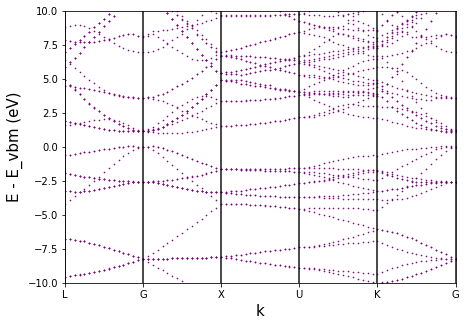

In [14]:
plotBands(E,pathDensity,a)